In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import plotly.graph_objects as go
from scipy.sparse.linalg import svds
from numpy.linalg import svd

In [114]:
df = pd.read_csv("full_data.csv")

In [3]:
df.head()

,user_id,item_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [4]:
print(f"users count: {df['user_id'].nunique()}")
print(f"movies count: {df['item_id'].nunique()}")
complete_num_entries = df['item_id'].nunique()*df['user_id'].nunique() 
print(complete_num_entries)
print(f'sparsity ratio: {len(df)/complete_num_entries}')

users count: 943
movies count: 1682
1586126
sparsity ratio: 0.06304669364224531


In [5]:
df.drop(columns=['timestamp'], inplace=True)

In [6]:
df.columns

Index(['user_id', 'item_id', 'rating', 'title'], dtype='object')

In [70]:
train_df = pd.read_csv("data.csv") 
test_df = pd.read_csv("test.csv") # test actually

In [72]:
train_df.shape

(81016, 4)

In [ ]:
# ---- 1. Train / Test split  ---------------------------------------------
# Hold out 10 % of ratings *per user* so that every user still
# has at least one rating left in the training set.

TEST_FRAC = 0.10 
RANDOM_STATE = 42 
rng = np.random.default_rng(RANDOM_STATE)

def stratified_user_split(ratings_df, test_frac=0.10, rng=None):
    """Return train_df, test_df with ≈ `test_frac` ratings per user."""
    if rng is None:
        rng = np.random.default_rng()
    test_mask = np.zeros(len(ratings_df), dtype=bool)

    # groupby preserves index positions, so we can mark rows directly
    for _, idx in ratings_df.groupby('user_id').groups.items():
        idx = np.asarray(idx)           # row indices for this user
        n_test = max(1, int(round(len(idx) * test_frac)))
        choose = rng.choice(idx, size=n_test, replace=False)
        test_mask[choose] = True

    test_df  = ratings_df.loc[test_mask].reset_index(drop=True)
    train_df = ratings_df.loc[~test_mask].reset_index(drop=True)
    return train_df, test_df

train_df, test_df = stratified_user_split(df, TEST_FRAC, rng)

print(f"Train  set size: {len(train_df):,} ratings")
print(f"Test   set size: {len(test_df):,} ratings")

# ---- 2. Build sparse utility matrix from *train* data --------------------
# Map the external IDs to 0‑based row / col indices
user_codes, user_uniques = pd.factorize(train_df['user_id'])
item_codes, item_uniques = pd.factorize(train_df['item_id'])

n_users = len(user_uniques)
n_items = len(item_uniques)

train_matrix = coo_matrix(
    (train_df['rating'].astype(np.float32), (user_codes, item_codes)),
    shape=(n_users, n_items),
    dtype=np.float32
).tocsr()      # CSR preferred for fast row slicing

print(f"Utility matrix shape: {train_matrix.shape}")
print(f"Non‑zero entries   : {train_matrix.nnz}")    

# ---- 3. Prepare test coordinates for RMSE -------------------------------
# Discard test rows that reference users or items unseen in training,
# because an SVD model built on `train_matrix` cannot predict them.
known_user = test_df['user_id'].isin(user_uniques)
known_item = test_df['item_id'].isin(item_uniques)
test_df = test_df[known_user & known_item].reset_index(drop=True)

# Convert IDs to integer row/col indices using the encoding from factorize
user_lookup = dict(zip(user_uniques, range(n_users)))
item_lookup = dict(zip(item_uniques, range(n_items)))

test_rows = test_df['user_id'].map(user_lookup).to_numpy()
test_cols = test_df['item_id'].map(item_lookup).to_numpy()
test_ratings = test_df['rating'].to_numpy(dtype=np.float32)

# You will later use (test_rows, test_cols, test_ratings)
# to compute RMSE against the predictions.

Train  set size: 90,012 ratings
Test   set size: 9,988 ratings
Utility matrix shape: (943, 1667)
Non‑zero entries   : 90012


In [91]:
user_codes, user_uniques = pd.factorize(train_df['user_id'])
item_codes, item_uniques = pd.factorize(train_df['item_id'])

n_users = len(user_uniques)
n_items = len(item_uniques)

train_matrix = coo_matrix(
    (train_df['rating'].astype(np.float32), (user_codes, item_codes)),
    shape=(n_users, n_items),
    dtype=np.float32
).tocsr()      # CSR preferred for fast row slicing

print(f"Utility matrix shape: {train_matrix.shape}")
print(f"Non-zero entries   : {train_matrix.nnz}")    

# ---- 3. Prepare test coordinates for RMSE -------------------------------
# Discard test rows that reference users or items unseen in training,
# because an SVD model built on `train_matrix` cannot predict them.
known_user = test_df['user_id'].isin(user_uniques)
known_item = test_df['item_id'].isin(item_uniques)
test_df = test_df[known_user & known_item].reset_index(drop=True)

# Convert IDs to integer row/col indices using the encoding from factorize
user_lookup = dict(zip(user_uniques, range(n_users)))
item_lookup = dict(zip(item_uniques, range(n_items)))

test_rows = test_df['user_id'].map(user_lookup).to_numpy()
test_cols = test_df['item_id'].map(item_lookup).to_numpy()
test_ratings = test_df['rating'].to_numpy(dtype=np.float32)


Utility matrix shape: (943, 1667)
Non-zero entries   : 90012


### Approach 1 – Raw Zero‑Fill SVD
 Logic:
 * Build a sparse ratings matrix (already done: `train_matrix`)
 * Replace every missing entry implicitly with 0 – nothing extra to do
 * Compute truncated SVD (rank k)
 * Reconstruct low‑rank approximation and evaluate RMSE on the test set
   NOTE: The 0 padding biases predictions but keeps the pipeline minimal.

In [ ]:

k = 30  # latent dimension

# Sparse SVD returns singular values in ascending order – reverse them
U, S, Vt = svds(train_matrix, k=k)
idx = np.argsort(-S)
U, S, Vt = U[:, idx], S[idx], Vt[idx, :]

# Full reconstruction (dense ~ 6 MB) – fine for MovieLens‑100k size
raw_pred = (U @ np.diag(S) @ Vt)
raw_pred_clipped = np.clip(raw_pred, 1, 5)

rmse_raw = np.sqrt(
    np.mean((raw_pred_clipped[test_rows, test_cols] - test_ratings) ** 2)
)
print(f"Raw Zero‑Fill SVD  | RMSE = {rmse_raw:.4f}")



Raw Zero‑Fill SVD  | RMSE = 2.2966


### Approach 2 – Mean‑Centred SVD
 Logic:
 * Subtract each user’s mean rating from their observed ratings.
   Unknown cells stay at 0 (≈ “no residual”).
 * Run truncated SVD on this centred residual matrix.
 * Add the user mean back to get final predictions, clip to [1,5], RMSE.

In [93]:
# Compute user means from *training* data only
user_sum = np.array(train_matrix.sum(axis=1)).flatten()
user_count = np.diff(train_matrix.indptr)
user_mean = user_sum / np.maximum(user_count, 1)       # avoid divide‑by‑0

# Build centred dense matrix
centred = train_matrix.toarray().astype(np.float32)
for u in range(centred.shape[0]):
    centred[u, centred[u, :] != 0] -= user_mean[u]     # subtract only on obs

# Note: zeros remain zeros in missing cells
Uc, Sc, Vtc = svds(centred, k=k)
idx = np.argsort(-Sc)
Uc, Sc, Vtc = Uc[:, idx], Sc[idx], Vtc[idx, :]
centred_pred = Uc @ np.diag(Sc) @ Vtc

# Add user mean baseline back
mean_pred = centred_pred + user_mean[:, None]
mean_pred_clipped = np.clip(mean_pred, 1, 5)

rmse_mean = np.sqrt(
    np.mean((mean_pred_clipped[test_rows, test_cols] - test_ratings) ** 2)
)
print(f"Mean‑Centred SVD   | RMSE = {rmse_mean:.4f}")





Mean‑Centred SVD   | RMSE = 0.9855


### Approach 3 – Z‑Score Normalised SVD
 Logic:
 * After mean‑centring, divide by each user’s standard deviation.
 * Run SVD on the z‑scored residuals.
 * Reverse the scaling (×σ + μ), clip, RMSE.

In [94]:
# Compute user standard deviation on observed ratings
residual = train_matrix.toarray().astype(np.float32)
for u in range(residual.shape[0]):
    mask = residual[u, :] != 0
    residual[u, mask] -= user_mean[u]

user_var = np.zeros_like(user_mean)
for u in range(residual.shape[0]):
    mask = residual[u, :] != 0
    if mask.sum():
        user_var[u] = np.mean(residual[u, mask] ** 2)
user_std = np.sqrt(np.maximum(user_var, 1e-12))   # avoid divide‑by‑0

zscored = residual.copy()
for u in range(zscored.shape[0]):
    zscored[u, zscored[u, :] != 0] /= user_std[u]

Uz, Sz, Vtz = svds(zscored, k=k)
idx = np.argsort(-Sz)
Uz, Sz, Vtz = Uz[:, idx], Sz[idx], Vtz[idx, :]
z_pred = Uz @ np.diag(Sz) @ Vtz

# Reverse z‑score
z_pred_rescaled = (z_pred * user_std[:, None]) + user_mean[:, None]
z_pred_clipped = np.clip(z_pred_rescaled, 1, 5)

rmse_z = np.sqrt(
    np.mean((z_pred_clipped[test_rows, test_cols] - test_ratings) ** 2)
)
print(f"Z‑Score SVD        | RMSE = {rmse_z:.4f}")

Z‑Score SVD        | RMSE = 0.9852


### Approach 4 – Iterative SVD‑Impute
 Logic:
 * Start with user‑mean initial guess for missing cells -> dense matrix X
 * Loop:
     a) rank‑k SVD of X -> P  (low‑rank projection)
     b) put the *true* ratings back into X (mask)
 * Stop after N iterations or when change < ε.
 * Evaluate RMSE on final projection.


In [95]:
from numpy.linalg import svd

n_iters = 5
ε = 1e-3

m, n = train_matrix.shape
X = np.zeros((m, n), dtype=np.float32)

# Initial fill with user mean
for u in range(m):
    X[u, :] = user_mean[u]
coo = train_matrix.tocoo()
X[coo.row, coo.col] = coo.data            # enforce observed ratings

mask_obs = np.zeros_like(X, dtype=bool)
mask_obs[coo.row, coo.col] = True

for t in range(n_iters):
    # SVD via dense routine (matrix only 6 MB)
    U_i, S_i, Vt_i = svd(X, full_matrices=False)
    U_i, S_i, Vt_i = U_i[:, :k], S_i[:k], Vt_i[:k, :]
    P = U_i @ np.diag(S_i) @ Vt_i

    delta = np.linalg.norm((~mask_obs) * (P - X)) / np.linalg.norm((~mask_obs) * X)
    X[~mask_obs] = P[~mask_obs]   # update only missing cells
    print(f"Iter {t+1}: rel_change = {delta:.4e}")
    if delta < ε:
        break

impute_pred = np.clip(P, 1, 5)
rmse_imp = np.sqrt(
    np.mean((impute_pred[test_rows, test_cols] - test_ratings) ** 2)
)
print(f"Iterative SVD‑Impute| RMSE = {rmse_imp:.4f}")

Iter 1: rel_change = 2.1579e-02
Iter 2: rel_change = 1.4402e-02


Iter 3: rel_change = 1.1320e-02
Iter 4: rel_change = 9.4860e-03
Iter 5: rel_change = 8.2364e-03
Iterative SVD‑Impute| RMSE = 0.9786


### Approach 5 - "baseline + latent factors"
* μ  : overall mean
* b_u: user bias
* b_i: item bias
* P  : rank-k SVD of residuals
* final prediction  r̂_ui = μ + b_u + b_i + P_ui

In [96]:
from scipy.sparse.linalg import svds
import numpy as np

k = 10                   # latent dimension  (tweak 20-50 for MovieLens-100k)

# --- 1. baselines ----------------------------------------------------------
mu = train_df['rating'].mean()

# user bias  b_u
user_mean = train_df.groupby('user_id')['rating'].mean()
b_u = (user_mean - mu).reindex(user_uniques).fillna(0.0).to_numpy()

# item bias  b_i
item_mean = train_df.groupby('item_id')['rating'].mean()
b_i = (item_mean - mu).reindex(item_uniques).fillna(0.0).to_numpy()

# --- 2. residual matrix ----------------------------------------------------
# Build dense matrix of residuals (MovieLens-100k ↔ ~13 MB float32)
residual = train_matrix.toarray().astype(np.float32)

# subtract μ + b_u + b_i **only** on observed entries
rows, cols = train_matrix.nonzero()
residual[rows, cols] -= (mu + b_u[rows] + b_i[cols])

# --- 3. rank-k SVD on residuals -------------------------------------------
U, S, Vt = svds(residual, k=k)
idx = np.argsort(-S)           # put largest σ first
U, S, Vt = U[:, idx], S[idx], Vt[idx, :]

P = U @ np.diag(S) @ Vt        # low-rank residuals

# --- 4. compose final predictions -----------------------------------------
pred = mu + b_u[:, None] + b_i[None, :] + P
pred_clipped = np.clip(pred, 1, 5)

# --- 5. evaluation ---------------------------------------------------------
rmse_bias_only = np.sqrt(
    np.mean((mu + b_u[test_rows] + b_i[test_cols] - test_ratings) ** 2)
)
rmse_bias_svd  = np.sqrt(
    np.mean((pred_clipped[test_rows, test_cols] - test_ratings) ** 2)
)

print(f"Baseline-only          | RMSE = {rmse_bias_only:.4f}")
print(f"Bias + Residual-SVD    | RMSE = {rmse_bias_svd :.4f}")


##################################################################################
# ①  Build latent user/item factors  (R ≈ Q · Pᵀ)  and test RMSE
# --------------------------------------------------------------------------
# Requires:  U, S, Vt  from the Bias-Residual SVD cell (k=10 there)
#            mu, b_u, b_i, user_uniques, item_uniques,
#            test_rows, test_cols, test_ratings
# --------------------------------------------------------------------------
sqrt_S   = np.sqrt(S)

# P_factors = U * sqrt_S            # users  (m × k)
# Q_factors = (Vt.T) * sqrt_S       # items  (n × k)

Q_factors = U                        # shape: (m × k)
P_t = np.diag(S) @ Vt                # shape: (k × n)
P_factors = P_t.T                    # shape: (n × k)

def predict_dot_only(u_row, i_col):
    """Residual interaction  q_u · p_i  (correct orientation)."""
    return float(Q_factors[u_row] @ P_factors[i_col])

def predict_full(u_row, i_col):
    return mu + b_u[u_row] + b_i[i_col] + predict_dot_only(u_row, i_col)

full_preds = np.clip(
    np.array([predict_full(u, i) for u, i in zip(test_rows, test_cols)]),
    1, 5
)

rmse_full = np.sqrt(np.mean((full_preds - test_ratings) ** 2))
print(f"A = Q · Pᵀ  | RMSE = {rmse_full:.4f}")



Baseline-only          | RMSE = 0.9708
Bias + Residual-SVD    | RMSE = 0.9358
A = Q · Pᵀ  | RMSE = 0.9358


In [97]:
residual.shape

(943, 1667)

In [98]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# --------------------------------------------------------------------------
# Preconditions (already in your namespace):
#   Q_factors     : (n_items × k) numpy array  – latent coords of movies
#   S             : length-k numpy array        – singular values
#   item_uniques  : sequence of item_id in training order
#   df            : original ratings DataFrame with at least 'item_id' and 'title'
# --------------------------------------------------------------------------

# --- 1. pick the top-3 latent factors by singular value energy -------------
top3_idx = np.argsort(-S)[:3]
f1, f2, f3 = top3_idx
print(f"Using latent factors {f1}, {f2}, {f3} (the three largest singular values).")

# --- 2. map item_id → title (deduplicated) ----------------------------------
id_to_title = (
    df[['item_id', 'title']]
      .drop_duplicates('item_id')
      .set_index('item_id')['title']
      .to_dict()
)
titles_all = [id_to_title.get(iid, str(iid)) for iid in item_uniques]

# --- 3. select a subset of movies for better visualization ------------------
#    Here: take the 100 most-rated movies (by count of ratings in df).
rating_counts = df['item_id'].value_counts()
top_n = 100
top_items = set(rating_counts.index[:top_n])

subset_mask = np.array([iid in top_items for iid in item_uniques])
subset_indices = np.where(subset_mask)[0]

# Extract latent coordinates and titles for the subset
xs3 = Q_factors[subset_indices, f1]
ys3 = Q_factors[subset_indices, f2]
zs3 = Q_factors[subset_indices, f3]
titles_subset = [titles_all[i] for i in subset_indices]

# --- 4. Plot #1: 3D scatter of top 3 latent factors --------------------------
fig3d = go.Figure(
    data=[
        go.Scatter3d(
            x=xs3,
            y=ys3,
            z=zs3,
            mode='markers',
            marker=dict(size=4, opacity=0.8, color='blue'),
            hovertext=titles_subset,
            hoverinfo='text'
        )
    ]
)
fig3d.update_layout(
    scene=dict(
        xaxis=dict(title=f"Latent factor {f1+1}"),
        yaxis=dict(title=f"Latent factor {f2+1}"),
        zaxis=dict(title=f"Latent factor {f3+1}")
    ),
    title=f"Top {top_n} Movies in 3D Latent Space (Factors {f1+1}, {f2+1}, {f3+1})",
    margin=dict(l=0, r=0, b=0, t=40)
)
fig3d.show()


# --- 5. Plot #2: 2D (factor f1 vs. f2) ----------------------------------------
x12 = Q_factors[subset_indices, f1]
y12 = Q_factors[subset_indices, f2]

fig12 = go.Figure(
    data=[
        go.Scatter(
            x=x12,
            y=y12,
            mode='markers',
            marker=dict(size=6, opacity=0.8, color='blue'),
            hovertext=titles_subset,
            hoverinfo='text'
        )
    ]
)
fig12.update_layout(
    xaxis=dict(title=f"Latent factor {f1+1}"),
    yaxis=dict(title=f"Latent factor {f2+1}"),
    title=f"Top {top_n} Movies in 2D Latent Space (Factors {f1+1} vs. {f2+1})",
    margin=dict(l=40, r=40, b=40, t=40)
)
fig12.show()


# --- 6. Plot #3: 2D (factor f2 vs. f3) ----------------------------------------
x23 = Q_factors[subset_indices, f2]
y23 = Q_factors[subset_indices, f3]

fig23 = go.Figure(
    data=[
        go.Scatter(
            x=x23,
            y=y23,
            mode='markers',
            marker=dict(size=6, opacity=0.8, color='green'),
            hovertext=titles_subset,
            hoverinfo='text'
        )
    ]
)
fig23.update_layout(
    xaxis=dict(title=f"Latent factor {f2+1}"),
    yaxis=dict(title=f"Latent factor {f3+1}"),
    title=f"Top {top_n} Movies in 2D Latent Space (Factors {f2+1} vs. {f3+1})",
    margin=dict(l=40, r=40, b=40, t=40)
)
fig23.show()


# --- 7. Plot #4: 2D (factor f1 vs. f3) ----------------------------------------
x13 = Q_factors[subset_indices, f1]
y13 = Q_factors[subset_indices, f3]

fig13 = go.Figure(
    data=[
        go.Scatter(
            x=x13,
            y=y13,
            mode='markers',
            marker=dict(size=6, opacity=0.8, color='red'),
            hovertext=titles_subset,
            hoverinfo='text'
        )
    ]
)
fig13.update_layout(
    xaxis=dict(title=f"Latent factor {f1+1}"),
    yaxis=dict(title=f"Latent factor {f3+1}"),
    title=f"Top {top_n} Movies in 2D Latent Space (Factors {f1+1} vs. {f3+1})",
    margin=dict(l=40, r=40, b=40, t=40)
)
fig13.show()


Using latent factors 0, 1, 2 (the three largest singular values).


### Approach 6 - Bias + Iterative SVD-Impute
* Final formula after convergence:
   r̂_ui = μ + b_u + b_i           (baseline)
           + residual learned by   rank-k hard-impute

In [ ]:
# ---------- 1. baselines ---------------------------------------------------
mu = train_df['rating'].mean()

user_mean = train_df.groupby('user_id')['rating'].mean()
b_u = (user_mean - mu).reindex(user_uniques).fillna(0.0).to_numpy()

item_mean = train_df.groupby('item_id')['rating'].mean()
b_i = (item_mean - mu).reindex(item_uniques).fillna(0.0).to_numpy()

# ---------- 2. initial dense matrix X -------------------------------------
m, n = train_matrix.shape
baseline_full = mu + b_u[:, None] + b_i[None, :]   # shape (m, n)

X = baseline_full.astype(np.float32).copy()

# insert the observed ratings back (they override the baseline)
coo = train_matrix.tocoo()
X[coo.row, coo.col] = coo.data

mask_obs = np.zeros_like(X, dtype=bool)
mask_obs[coo.row, coo.col] = True

# ---------- 3. iterative hard-impute --------------------------------------
k        = 30        # latent dimension
n_iters  = 5
eps      = 1e-3

for t in range(n_iters):
    # rank-k SVD
    U, S, Vt = svd(X, full_matrices=False)
    U, S, Vt = U[:, :k], S[:k], Vt[:k, :]
    P = U @ np.diag(S) @ Vt               # low-rank approximation

    # relative change on missing cells
    delta = np.linalg.norm((~mask_obs) * (P - X)) / np.linalg.norm((~mask_obs) * X)
    print(f"Iter {t+1}: rel_change = {delta:.4e}")

    # update only the missing entries
    X[~mask_obs] = P[~mask_obs]

    if delta < eps:
        break

# ---------- 4. predictions & evaluation -----------------------------------
pred_bias      = mu + b_u[test_rows] + b_i[test_cols]          # baseline only
pred_bias_svd  = np.clip(X, 1, 5)[test_rows, test_cols]        # bias + latent

rmse_baseline  = np.sqrt(np.mean((pred_bias      - test_ratings) ** 2))
rmse_bias_svd  = np.sqrt(np.mean((pred_bias_svd  - test_ratings) ** 2))

print(f"Baseline-only           | RMSE = {rmse_baseline:.4f}")
print(f"Bias + Iterative SVD    | RMSE = {rmse_bias_svd :.4f}")


Iter 1: rel_change = 2.0798e-02
Iter 2: rel_change = 1.4298e-02
Iter 3: rel_change = 1.1407e-02
Iter 4: rel_change = 9.6533e-03
Iter 5: rel_change = 8.4442e-03
Baseline-only           | RMSE = 0.9708
Bias + Iterative SVD    | RMSE = 0.9567


### RMSE VS K plot

In [ ]:
def _rmse(matrix_pred, rows, cols, true):
    """Compute RMSE on the (rows, cols) coordinates."""
    return float(np.sqrt(np.mean((matrix_pred[rows, cols] - true) ** 2)))

# ---------------------------------------------------------------------------
#  Approach 1 ― Raw Zero-Fill SVD
# ---------------------------------------------------------------------------
def raw_zero_fill_svd(k: int,return_preds=False) -> float:
    U, S, Vt = svds(train_matrix, k=k)                # ascending σ
    idx       = np.argsort(-S)                        # largest first
    U, S, Vt  = U[:, idx], S[idx], Vt[idx, :]

    pred  = U @ np.diag(S) @ Vt                       # dense ≈ 6 MB
    pred  = np.clip(pred, 1, 5)                       # ratings domain
    if return_preds:
        return pred
    return _rmse(pred, test_rows, test_cols, test_ratings)

# ---------------------------------------------------------------------------
#  Approach 2 ― Mean-Centred SVD
# ---------------------------------------------------------------------------
def mean_centred_svd(k: int,return_preds=False) -> float:
    # user means on *training* ratings
    user_sum   = np.asarray(train_matrix.sum(axis=1)).ravel()
    user_count = np.diff(train_matrix.indptr)
    user_mean  = user_sum / np.maximum(user_count, 1)

    centred = train_matrix.toarray().astype(np.float32)
    for u in range(centred.shape[0]):
        mask = centred[u] != 0
        centred[u, mask] -= user_mean[u]

    U, S, Vt = svds(centred, k=k)
    idx      = np.argsort(-S)
    centred  = (U[:, idx] @ np.diag(S[idx]) @ Vt[idx])
    pred     = np.clip(centred + user_mean[:, None], 1, 5)
    if return_preds:
        return pred
    return _rmse(pred, test_rows, test_cols, test_ratings)

# ---------------------------------------------------------------------------
#  Approach 3 ― Z-Score Normalised SVD
# ---------------------------------------------------------------------------
def z_score_normalised_svd(k: int,return_preds=False) -> float:
    # reuse user_mean from approach 2
    user_sum   = np.asarray(train_matrix.sum(axis=1)).ravel()
    user_count = np.diff(train_matrix.indptr)
    user_mean  = user_sum / np.maximum(user_count, 1)

    residual = train_matrix.toarray().astype(np.float32)
    for u in range(residual.shape[0]):
        mask = residual[u] != 0
        residual[u, mask] -= user_mean[u]

    # user std on observed entries
    user_var = np.zeros_like(user_mean)
    for u in range(residual.shape[0]):
        mask = residual[u] != 0
        if mask.sum():
            user_var[u] = np.mean(residual[u, mask] ** 2)
    user_std = np.sqrt(np.maximum(user_var, 1e-12))

    z = residual.copy()
    for u in range(z.shape[0]):
        mask = z[u] != 0
        z[u, mask] /= user_std[u]

    U, S, Vt = svds(z, k=k)
    idx      = np.argsort(-S)
    z_pred   = U[:, idx] @ np.diag(S[idx]) @ Vt[idx]
    pred     = np.clip(z_pred * user_std[:, None] + user_mean[:, None], 1, 5)
    if return_preds:
        return pred
    return _rmse(pred, test_rows, test_cols, test_ratings)

# ---------------------------------------------------------------------------
#  Approach 4 ― Iterative SVD-Impute
# ---------------------------------------------------------------------------
def iterative_svd_impute(k: int, n_iters: int = 5, tol: float = 1e-3,return_preds=False) -> float:
    m, n  = train_matrix.shape
    X     = np.zeros((m, n), np.float32)

    # initialise with user means
    user_sum   = np.asarray(train_matrix.sum(axis=1)).ravel()
    user_count = np.diff(train_matrix.indptr)
    user_mean  = user_sum / np.maximum(user_count, 1)
    X[:]       = user_mean[:, None]

    coo        = train_matrix.tocoo()
    mask_obs   = np.zeros_like(X, bool)
    X[coo.row, coo.col]   = coo.data
    mask_obs[coo.row, coo.col] = True            # True = training ratings

    for _ in range(n_iters):
        U, S, Vt = svd(X, full_matrices=False)
        U, S, Vt = U[:, :k], S[:k], Vt[:k]
        P        = U @ np.diag(S) @ Vt

        delta = np.linalg.norm(~mask_obs * (P - X)) / np.linalg.norm(~mask_obs * X)
        X[~mask_obs] = P[~mask_obs]
        if delta < tol:
            break

    pred = np.clip(X, 1, 5)
    if return_preds:
        return pred
    return _rmse(pred, test_rows, test_cols, test_ratings)

# ---------------------------------------------------------------------------
#  Approach 5 ― baseline + latent factors
# ---------------------------------------------------------------------------
def baseline_latent_factors(k: int,return_preds=False) -> float:
    mu = train_df['rating'].mean()

    # user / item biases
    b_u = (train_df.groupby('user_id')['rating'].mean() - mu) \
            .reindex(user_uniques).fillna(0.).to_numpy()
    b_i = (train_df.groupby('item_id')['rating'].mean() - mu) \
            .reindex(item_uniques).fillna(0.).to_numpy()

    # residuals matrix
    residual = train_matrix.toarray().astype(np.float32)
    rows, cols = train_matrix.nonzero()
    residual[rows, cols] -= mu + b_u[rows] + b_i[cols]

    # rank-k SVD on residuals
    U, S, Vt = svds(residual, k=k)
    idx = np.argsort(-S)
    U, S, Vt = U[:, idx], S[idx], Vt[idx]
    P = U @ np.diag(S) @ Vt                       # low-rank residuals

    pred = np.clip(mu + b_u[:, None] + b_i[None, :] + P, 1, 5)
    if return_preds:
        return pred
    return _rmse(pred, test_rows, test_cols, test_ratings)

# ---------------------------------------------------------------------------
#  Approach 6 ― Bias + Iterative SVD-Impute
# ---------------------------------------------------------------------------
def bias_iterative_svd_impute(k: int, n_iters: int = 5, tol: float = 1e-3,return_preds=False) -> float:
    mu = train_df['rating'].mean()
    b_u = (train_df.groupby('user_id')['rating'].mean() - mu) \
            .reindex(user_uniques).fillna(0.).to_numpy()
    b_i = (train_df.groupby('item_id')['rating'].mean() - mu) \
            .reindex(item_uniques).fillna(0.).to_numpy()

    m, n = train_matrix.shape
    X = (mu + b_u[:, None] + b_i[None, :]).astype(np.float32)

    coo = train_matrix.tocoo()
    mask_obs = np.zeros_like(X, bool)
    X[coo.row, coo.col]   = coo.data
    mask_obs[coo.row, coo.col] = True

    for _ in range(n_iters):
        U, S, Vt = svd(X, full_matrices=False)
        U, S, Vt = U[:, :k], S[:k], Vt[:k]
        P = U @ np.diag(S) @ Vt

        delta = np.linalg.norm(~mask_obs * (P - X)) / np.linalg.norm(~mask_obs * X)
        X[~mask_obs] = P[~mask_obs]
        if delta < tol:
            break

    pred = np.clip(X, 1, 5)
    if return_preds:
        return pred
    return _rmse(pred, test_rows, test_cols, test_ratings)

# # ---------------------------------------------------------------------------
# #  Sweep k = 5 … 60  and collect all results
# # ---------------------------------------------------------------------------
k_values        = range(5, 61, 5)
results_dict    = {
    "Raw Zero-Fill SVD":            {k: raw_zero_fill_svd(k)           for k in k_values},
    "Mean-Centred SVD":             {k: mean_centred_svd(k)            for k in k_values},
    "Z-Score Normalised SVD":       {k: z_score_normalised_svd(k)      for k in k_values},
    "Iterative SVD-Impute":         {k: iterative_svd_impute(k)        for k in k_values},
    "baseline + latent factors":    {k: baseline_latent_factors(k)     for k in k_values},
    "Bias + Iterative SVD-Impute":  {k: bias_iterative_svd_impute(k)    for k in k_values},
}



### report on train

In [101]:
# Prepare train coordinates for RMSE
train_rows = train_df['user_id'].map(user_lookup).to_numpy()
train_cols = train_df['item_id'].map(item_lookup).to_numpy()
train_ratings = train_df['rating'].to_numpy(dtype=np.float32)
results_dict    = {}
for name, fn in [
    ("Raw Zero-Fill SVD", raw_zero_fill_svd),
    ("Mean-Centred SVD", mean_centred_svd),
    ("Z-Score Normalised SVD", z_score_normalised_svd),
    ("Iterative SVD-Impute", iterative_svd_impute),
    ("baseline + latent factors", baseline_latent_factors),
    ("Bias + Iterative SVD-Impute", bias_iterative_svd_impute),
]:
    method_results = {}
    for k in k_values:
        pred = fn(k, return_preds=True)
        train_rmse = _rmse(pred, train_rows, train_cols, train_ratings)
        test_rmse  = _rmse(pred, test_rows, test_cols, test_ratings)
        method_results[k] = {'train': train_rmse, 'test': test_rmse}
    results_dict[name] = method_results


In [102]:
# --- Test RMSE plot ---
fig_test = go.Figure()
for name, scores in results_dict.items():
    ks   = sorted(scores)
    rms  = [scores[k]['test'] for k in ks]
    fig_test.add_trace(
        go.Scatter(
            x = ks,
            y = rms,
            mode = "lines+markers",
            name = name,
            hovertemplate = (
                "<b>%{meta}</b><br>"
                "k = %{x}<br>"
                "Test RMSE = %{y:.4f}<extra></extra>"
            ),
            meta = name,
            marker = dict(size=8)
        )
    )
fig_test.update_layout(
    title = "Effect of latent dimension k on MovieLens-100k (Test RMSE)",
    xaxis_title = "Latent dimension  k",
    yaxis_title = "Test RMSE (10 % hold-out test set)",
    template    = "plotly_white",
    legend_title = "Approach",
    hovermode   = "closest",
    width       = 800,
    height      = 500,
)

# --- Train RMSE plot ---
fig_train = go.Figure()
for name, scores in results_dict.items():
    ks   = sorted(scores)
    rms  = [scores[k]['train'] for k in ks]
    fig_train.add_trace(
        go.Scatter(
            x = ks,
            y = rms,
            mode = "lines+markers",
            name = name,
            hovertemplate = (
                "<b>%{meta}</b><br>"
                "k = %{x}<br>"
                "Train RMSE = %{y:.4f}<extra></extra>"
            ),
            meta = name,
            marker = dict(size=8)
        )
    )
fig_train.update_layout(
    title = "Effect of latent dimension k on MovieLens-100k (Train RMSE)",
    xaxis_title = "Latent dimension  k",
    yaxis_title = "Train RMSE (on training set)",
    template    = "plotly_white",
    legend_title = "Approach",
    hovermode   = "closest",
    width       = 800,
    height      = 500,
)

# Show both figures
fig_test.show()
fig_train.show()


In [103]:
fig_test.write_html("rmse_vs_k.html", include_plotlyjs="cdn")

### inspect Q and P_t

In [104]:
from scipy.sparse.linalg import svds
import numpy as np

# ------------------------
# 1. Baselines: μ, b_u, b_i
# ------------------------

# Global mean rating
mu = train_df['rating'].mean()

# User‐bias b_u (length = #users)
user_mean = train_df.groupby('user_id')['rating'].mean()
b_u = (user_mean - mu).reindex(user_uniques).fillna(0.0).to_numpy()

# Item‐bias b_i (length = #items)
item_mean = train_df.groupby('item_id')['rating'].mean()
b_i = (item_mean - mu).reindex(item_uniques).fillna(0.0).to_numpy()


# --------------------------------------------------------
# 2. Build “residual” matrix Rᵀ (rows = items, cols = users)
# --------------------------------------------------------

# Convert the sparse train_matrix (users × items) to dense and transpose:
#   R  (users × items)  →  Rᵀ (items × users)
residual = train_matrix.toarray().astype(np.float32).T

# Subtract (μ + b_u[u] + b_i[i]) on each observed entry (u, i).
users_idx, items_idx = train_matrix.nonzero()
residual[items_idx, users_idx] -= (mu + b_u[users_idx] + b_i[items_idx])


# ---------------------------------------------
# 3. Compute rank‐k SVD on Rᵀ = U Σ Vᵀ (items × users)
# ---------------------------------------------

k = 10  # latent dimension

# U: (n_items × k), S: (k,), Vt: (k × n_users)
U, S, Vt = svds(residual, k=k)

# Sort singular values in descending order, reorder U, S, Vt
order = np.argsort(-S)
U, S, Vt = U[:, order], S[order], Vt[order, :]

# Reconstruct the low‐rank residual (optional check):
# R_hat = U @ np.diag(S) @ Vt   # shape: (n_items × n_users)


# ---------------------------------------------------
# 4. Assign A, Q, and Pᵀ to match “R ≈ Q · Pᵀ” diagram
# ---------------------------------------------------

# According to the diagram:
#   A  = R   (here: R ≡ residual, shape = items × users)
A = residual

#   Q  = U   (items × k)
Q = U

#   Pᵀ = Σ · Vᵀ   (shape = k × users)
P_t = np.diag(S) @ Vt   # (k × n_users)

# Verify that A ≈ Q @ Pᵀ:
#   A_hat = Q @ P_t       # (n_items × n_users)
# If you want to check reconstruction error:
# A_hat = Q @ P_t
# print("Reconstruction error:", np.linalg.norm(A - A_hat))


# --------------------------------------------
# 5. Build full “user × item” prediction matrix
# --------------------------------------------

# We have:
#   Q (items × k)
#   P_t (k × users)
# ⇒   P   = (P_t)ᵀ  (users × k)

P = P_t.T  # shape: (n_users × k)

# Now reconstruct the residual for each (user, item) as:
#   residual_hat[u, i] = (Q[i, :] · P[u, :])
# We can form a full matrix by taking (P @ Qᵀ)ᵀ, but here we’ll do it elementwise:

# ‣ Full “users × items” residual matrix:
residual_hat_T = (P @ Q.T)  # shape: (n_users × n_items)

# Compose the baseline + residual:
#   pred_full[u, i] = μ + b_u[u] + b_i[i] + residual_hat_T[u, i]
pred_matrix = (
    mu
    + b_u[:, None]     # broadcast to (n_users × 1)
    + b_i[None, :]     # broadcast to (1 × n_items)
    + residual_hat_T   # (n_users × n_items)
)

# Clip predictions into valid rating range [1, 5]:
pred_clipped = np.clip(pred_matrix, 1.0, 5.0)


# --------------------------------------------
# 6. Evaluate on held‐out test set
# --------------------------------------------

# test_rows, test_cols: arrays of user‐indices and item‐indices for test entries
# test_ratings: array of ground‐truth ratings

# (a) Bias‐only RMSE
rmse_bias_only = np.sqrt(
    np.mean(
        ( (mu + b_u[test_rows] + b_i[test_cols]) - test_ratings ) ** 2
    )
)

# (b) Bias + Residual‐SVD RMSE
preds_test = pred_clipped[test_rows, test_cols]
rmse_bias_svd = np.sqrt(np.mean((preds_test - test_ratings) ** 2))

print(f"Baseline‐only RMSE         = {rmse_bias_only:.4f}")
print(f"Bias + Residual‐SVD RMSE   = {rmse_bias_svd:.4f}")


# --------------------------------------------
# 7. Print shapes to confirm A, Q, Pᵀ
# --------------------------------------------

print(f"A   (items × users)   = {A.shape}")
print(f"Q   (items × factors) = {Q.shape}")
print(f"Pᵀ  (factors × users) = {P_t.shape}")


Baseline‐only RMSE         = 0.9708
Bias + Residual‐SVD RMSE   = 0.9358
A   (items × users)   = (1667, 943)
Q   (items × factors) = (1667, 10)
Pᵀ  (factors × users) = (10, 943)


#### Energy and Explained Variance

Computing full SVD of residual …
r =   1 | cum-var = 0.025 | RMSE = 0.9553
r =   2 | cum-var = 0.043 | RMSE = 0.9495
r =   3 | cum-var = 0.058 | RMSE = 0.9462
r =   5 | cum-var = 0.082 | RMSE = 0.9420
r =  10 | cum-var = 0.128 | RMSE = 0.9358
r =  15 | cum-var = 0.167 | RMSE = 0.9359
r =  20 | cum-var = 0.202 | RMSE = 0.9376
r =  30 | cum-var = 0.264 | RMSE = 0.9403
r =  40 | cum-var = 0.319 | RMSE = 0.9441
r =  50 | cum-var = 0.367 | RMSE = 0.9465
r =  75 | cum-var = 0.470 | RMSE = 0.9500
r = 100 | cum-var = 0.553 | RMSE = 0.9541


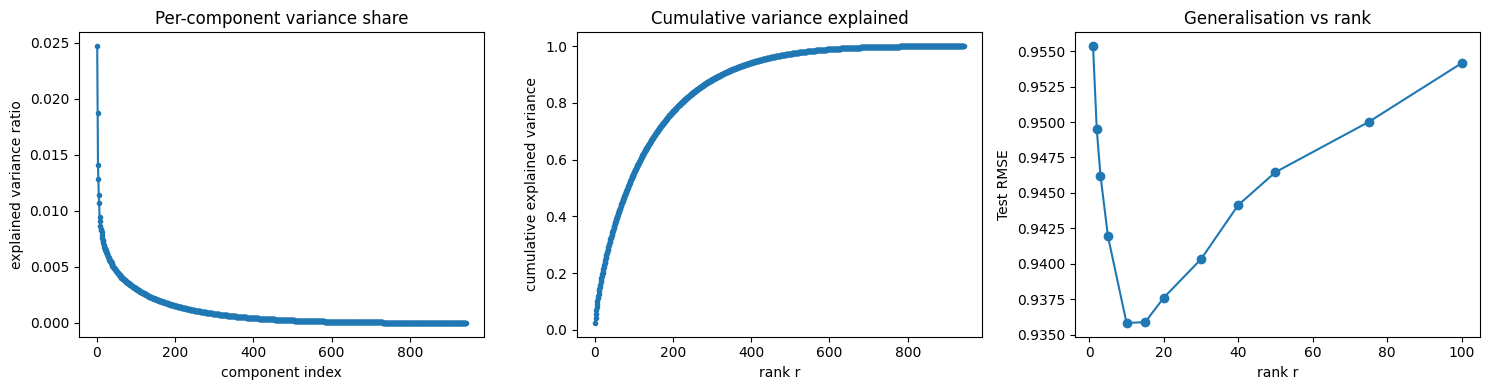

In [105]:
# ============================================================
# SECTION 1 – Energy & Truncation Experiments
# ------------------------------------------------------------
#  • per-component explained-variance ratio  (σ² / Σσ²)
#  • cumulative explained variance
#  • test-set RMSE vs rank
# ============================================================

import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1.1  Full SVD
# ------------------------------------------------------------
print("Computing full SVD of residual …")
U_full, S_full, Vt_full = svd(residual.T, full_matrices=False)
m = len(S_full)                       # m = min(n_items, n_users)

# ------------------------------------------------------------
# 1.2  Variance metrics
# ------------------------------------------------------------
energy_total          = np.sum(S_full**2)        # Σσ²  (total variance)
var_ratio             = (S_full**2) / energy_total        # per-component
cum_var_ratio         = np.cumsum(var_ratio)              # cumulative

# ------------------------------------------------------------
# 1.3  Evaluate RMSE vs rank r
# ------------------------------------------------------------
r_values   = [1, 2, 3, 5, 10, 15, 20, 30, 40, 50, 75, 100]
rmse_vs_r  = []

for r in r_values:
    if r > m:
        break

    Q_r = U_full[:, :r] # items × factors
    P_t = np.diag(S_full[:r]) @ Vt_full[:r, :] # factors × users

    residual_hat_T = Q_r @ P_t
    preds_full = (
        mu + b_u[:, None] + b_i[None, :] + residual_hat_T
    )
    preds_full = np.clip(preds_full, 1., 5.)
    preds_test = preds_full[test_rows, test_cols]
    rmse_r     = np.sqrt(np.mean((preds_test - test_ratings) ** 2))
    rmse_vs_r.append(rmse_r)

    print(f"r = {r:3d} | "
          f"cum-var = {cum_var_ratio[r-1]:.3f} | "
          f"RMSE = {rmse_r:.4f}")

# ------------------------------------------------------------
# 1.4  Plots
# ------------------------------------------------------------
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# (a) Per-component explained variance
ax[0].plot(np.arange(1, m+1), var_ratio, marker='.')
ax[0].set_xlabel("component index")
ax[0].set_ylabel("explained variance ratio")
ax[0].set_title("Per-component variance share")

# (b) Cumulative explained variance
ax[1].plot(np.arange(1, m+1), cum_var_ratio, marker='.')
ax[1].set_xlabel("rank r")
ax[1].set_ylabel("cumulative explained variance")
ax[1].set_title("Cumulative variance explained")

# (c) RMSE vs rank
ax[2].plot(r_values[:len(rmse_vs_r)], rmse_vs_r, marker='o')
ax[2].set_xlabel("rank r")
ax[2].set_ylabel("Test RMSE")
ax[2].set_title("Generalisation vs rank")

plt.tight_layout()
plt.show()


Computing full SVD of residual …
r =   1  |  energy = 0.025  |  RMSE = 0.9553
r =   2  |  energy = 0.043  |  RMSE = 0.9495
r =   3  |  energy = 0.058  |  RMSE = 0.9462
r =   5  |  energy = 0.082  |  RMSE = 0.9420
r =  10  |  energy = 0.128  |  RMSE = 0.9358
r =  15  |  energy = 0.167  |  RMSE = 0.9359
r =  20  |  energy = 0.202  |  RMSE = 0.9376
r =  30  |  energy = 0.264  |  RMSE = 0.9403
r =  40  |  energy = 0.319  |  RMSE = 0.9441
r =  50  |  energy = 0.367  |  RMSE = 0.9465
r =  75  |  energy = 0.470  |  RMSE = 0.9500
r = 100  |  energy = 0.553  |  RMSE = 0.9541


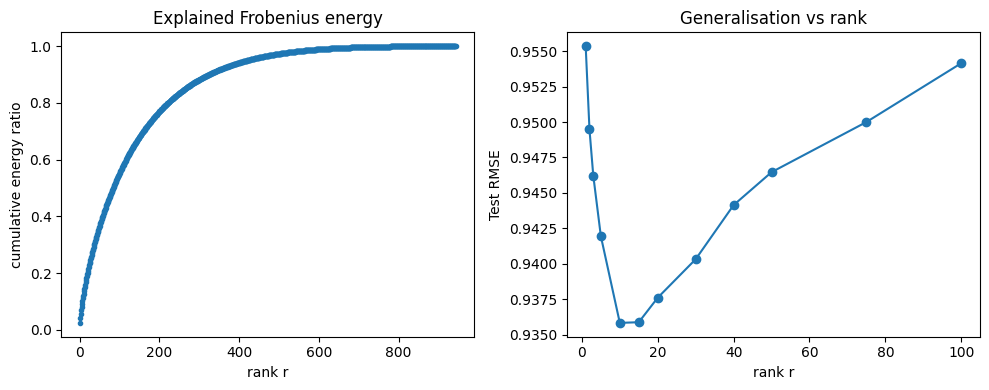

In [106]:
# ============================================================
# SECTION 1 – Energy & Truncation Experiments
# ------------------------------------------------------------
#  • How much Frobenius energy is captured by the first r
#    singular values?
#  • How does test-set RMSE vary with r?
# ============================================================

import numpy as np
from numpy.linalg import svd          # dense SVD (fits ML-100K fine)
# If you expect a much larger matrix, switch to svds + choose
#   a reasonably large k_max instead of full SVD.

# ------------------------------------------------------------
# 1.1  Full SVD  (U_full: items×m,  S_full: m,  Vt_full: m×users)
# ------------------------------------------------------------
print("Computing full SVD of residual …")
U_full, S_full, Vt_full = svd(residual.T, full_matrices=False)
m = len(S_full)                       # m = min(n_items, n_users)

# ------------------------------------------------------------
# 1.2  Cumulative energy curve
# ------------------------------------------------------------
energy_total      = np.sum(S_full**2)           # ‖Σ‖_F²
cum_energy_ratio  = np.cumsum(S_full**2) / energy_total  # length m

# ------------------------------------------------------------
# 1.3  Evaluate RMSE vs rank r
# ------------------------------------------------------------
# Choose the r values you want to inspect.
r_values = [1, 2, 3, 5, 10, 15, 20, 30, 40, 50, 75, 100]

rmse_vs_r = []

for r in r_values:
    if r > m:          # guard against asking for more than m factors
        break

    # --- low-rank factors ----------------------------------
    Q_r = U_full[:, :r] # items × factors
    P_t = np.diag(S_full[:r]) @ Vt_full[:r, :] # factors × users

    # --- predict residual on *all* (u,i) -------------------
    residual_hat_T = Q_r @ P_t

    # --- full prediction matrix ----------------------------
    preds_full = (
        mu
        + b_u[:, None]
        + b_i[None, :]
        + residual_hat_T
    )
    preds_full = np.clip(preds_full, 1., 5.)     # [1,5] domain

    # --- RMSE on held-out test -----------------------------
    preds_test = preds_full[test_rows, test_cols]
    rmse_r     = np.sqrt(np.mean((preds_test - test_ratings) ** 2))
    rmse_vs_r.append(rmse_r)

    print(f"r = {r:3d}  |  energy = {cum_energy_ratio[r-1]:.3f}  |  RMSE = {rmse_r:.4f}")

# ------------------------------------------------------------
# 1.4  Optional: quick Matplotlib plots
# ------------------------------------------------------------
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# (a) Energy curve
ax[0].plot(np.arange(1, m+1), cum_energy_ratio, marker='.')
ax[0].set_xlabel("rank r")
ax[0].set_ylabel("cumulative energy ratio")
ax[0].set_title("Explained Frobenius energy")

# (b) RMSE curve
ax[1].plot(r_values[:len(rmse_vs_r)], rmse_vs_r, marker='o')
ax[1].set_xlabel("rank r")
ax[1].set_ylabel("Test RMSE")
ax[1].set_title("Generalisation vs rank")

plt.tight_layout()
plt.show()


### Latent factor interpretation

In [107]:
# ======================================================================
# PART 2 – Factor Interpretation
# ======================================================================
TOP_N = 10        # how many movies to display at each end
k     = Q.shape[1]

# --- helpers -----------------------------------------------------------
title_lookup = (
    train_df.drop_duplicates('item_id')
            .set_index('item_id')['title']
            .reindex(item_uniques)            # align order with Q
)

# Add lightweight metadata we can get without extra files -------------
meta = pd.DataFrame({
    'item_id'      : item_uniques,
    'title'        : title_lookup.values,
    'rating_count' : train_df.groupby('item_id').size().reindex(item_uniques).fillna(0).astype(int),
    'mean_rating'  : train_df.groupby('item_id')['rating'].mean().reindex(item_uniques).fillna(np.nan) # only observed raitings
})

# Try to parse (1995) style years from titles
meta['year'] = (
    meta['title'].str.extract(r'\((\d{4})\)', expand=False)
                 .astype(float)
)

# ----------------------------------------------------------------------
# 2.1  Top / bottom tables
# ----------------------------------------------------------------------
for latent_factor in range(3):
    factor_vals = Q[:, latent_factor]

    top_idx    = np.argsort(-factor_vals)[:TOP_N]
    bottom_idx = np.argsort( factor_vals)[:TOP_N]

    print("\n" + "="*60)
    print(f"Factor {latent_factor+1}/{k}")
    print("-"*60)

    print("▶ Highest-loading movies")
    display(
        meta.loc[top_idx, ['title', 'rating_count', 'mean_rating', 'year']]
        .assign(weight=factor_vals[top_idx])
    )

    print("\n▶ Lowest-loading movies")
    display(
        meta.loc[bottom_idx, ['title', 'rating_count', 'mean_rating', 'year']]
        .assign(weight=factor_vals[bottom_idx])
    )


Factor 1/10
------------------------------------------------------------
▶ Highest-loading movies


,title,rating_count,mean_rating,year,weight
470,Tombstone (1993),98,3.663265,1993.0,0.081069
304,Fly Away Home (1996),135,3.533333,1996.0,0.063756
269,"Full Monty, The (1997)",282,3.936170,1997.0,0.062247
669,Body Parts (1991),13,1.615385,1991.0,0.058265
336,Playing God (1997),39,2.564103,1997.0,0.055559
483,Casablanca (1942),219,4.465753,1942.0,0.052785
395,Robin Hood: Men in Tights (1993),51,2.549020,1993.0,0.046803
624,"Three Caballeros, The (1945)",19,3.473684,1945.0,0.046186
199,"Bridge on the River Kwai, The (1957)",152,4.184211,1957.0,0.044297
106,Diabolique (1996),62,2.854839,1996.0,0.043640



▶ Lowest-loading movies


,title,rating_count,mean_rating,year,weight
380,Star Trek: Generations (1994),101,3.277228,1994.0,-0.203162
48,Hoop Dreams (1994),100,4.100000,1994.0,-0.160878
233,Under Siege (1992),112,3.294643,1992.0,-0.153376
92,True Romance (1993),94,3.627660,1993.0,-0.152422
460,"Crossing Guard, The (1995)",27,3.074074,1995.0,-0.137468
328,Conspiracy Theory (1997),271,3.413284,1997.0,-0.134420
145,"Lawnmower Man, The (1992)",60,2.383333,1992.0,-0.125453
126,"Spitfire Grill, The (1996)",82,3.939024,1996.0,-0.123076
215,Field of Dreams (1989),195,3.697436,1989.0,-0.119414
54,Outbreak (1995),95,3.221053,1995.0,-0.118934



Factor 2/10
------------------------------------------------------------
▶ Highest-loading movies


,title,rating_count,mean_rating,year,weight
199,"Bridge on the River Kwai, The (1957)",152,4.184211,1957.0,0.208455
337,"House of Yes, The (1997)",18,3.000000,1997.0,0.169287
174,Raiders of the Lost Ark (1981),368,4.247283,1981.0,0.165029
395,Robin Hood: Men in Tights (1993),51,2.549020,1993.0,0.147706
145,"Lawnmower Man, The (1992)",60,2.383333,1992.0,0.140360
310,"Rainmaker, The (1997)",124,3.596774,1997.0,0.134332
26,"Brothers McMullen, The (1995)",62,3.467742,1995.0,0.130695
318,Schindler's List (1993),273,4.498168,1993.0,0.108530
225,101 Dalmatians (1996),96,2.916667,1996.0,0.106778
93,Welcome to the Dollhouse (1995),107,3.747664,1995.0,0.099905



▶ Lowest-loading movies


,title,rating_count,mean_rating,year,weight
380,Star Trek: Generations (1994),101,3.277228,1994.0,-0.153059
21,Muppet Treasure Island (1996),77,2.792208,1996.0,-0.111897
159,Basic Instinct (1992),85,3.305882,1992.0,-0.085853
627,Robin Hood: Prince of Thieves (1991),67,3.223881,1991.0,-0.082471
260,Event Horizon (1997),112,2.562500,1997.0,-0.076272
89,Blade Runner (1982),239,4.117155,1982.0,-0.074994
530,"Man Who Would Be King, The (1975)",73,4.013699,1975.0,-0.074623
552,Species (1995),42,2.904762,1995.0,-0.069224
344,"Apostle, The (1997)",47,3.574468,1997.0,-0.069116
126,"Spitfire Grill, The (1996)",82,3.939024,1996.0,-0.064781



Factor 3/10
------------------------------------------------------------
▶ Highest-loading movies


,title,rating_count,mean_rating,year,weight
347,Wag the Dog (1997),120,3.516667,1997.0,0.143993
395,Robin Hood: Men in Tights (1993),51,2.549020,1993.0,0.133477
242,Kolya (1996),100,4.030000,1996.0,0.128562
194,"Sting, The (1973)",214,4.060748,1973.0,0.124149
126,"Spitfire Grill, The (1996)",82,3.939024,1996.0,0.124051
291,Absolute Power (1997),113,3.345133,1997.0,0.119764
199,"Bridge on the River Kwai, The (1957)",152,4.184211,1957.0,0.112287
11,Seven (Se7en) (1995),221,3.855204,1995.0,0.111684
337,"House of Yes, The (1997)",18,3.000000,1997.0,0.110603
527,Gandhi (1982),180,4.027778,1982.0,0.106191



▶ Lowest-loading movies


,title,rating_count,mean_rating,year,weight
7,Twelve Monkeys (1995),356,3.792135,1995.0,-0.133963
457,Free Willy 3: The Rescue (1997),23,1.652174,1997.0,-0.079389
441,"Amityville Horror, The (1979)",44,2.590909,1979.0,-0.078439
151,Willy Wonka and the Chocolate Factory (1971),296,3.635135,1971.0,-0.077075
660,Fried Green Tomatoes (1991),138,3.731884,1991.0,-0.076203
210,Indiana Jones and the Last Crusade (1989),292,3.958904,1989.0,-0.076018
193,"Right Stuff, The (1983)",148,3.918919,1983.0,-0.073580
737,Sirens (1994),55,2.927273,1994.0,-0.070052
343,Alien: Resurrection (1997),117,3.094017,1997.0,-0.069338
389,Black Beauty (1994),24,3.416667,1994.0,-0.067931


In [ ]:
# P           : (n_users × k) numpy array of user‐latent coordinates
# Q           : (n_items × k) numpy array of item‐latent coordinates
# item_uniques: array/list of all item_id’s, in the same order as Q’s rows
# user_uniques: array/list of all user_id’s, in the same order as P’s rows


TOP_N = 5       # the ten movies (highest + lowest on factor 1)
N_SHOW = 3       # how many “extreme” users to pick on each end

# 1) Identify which 10 movies are “highest” and “lowest” for factor 1
factor_vals = Q[:, 0]  # first latent dimension of Q
top_item_idx    = np.argsort(-factor_vals)[:TOP_N]
bottom_item_idx = np.argsort( factor_vals)[:TOP_N]

# Map those indices to actual item_id’s and titles
top_item_ids    = [item_uniques[i] for i in top_item_idx]
bottom_item_ids = [item_uniques[i] for i in bottom_item_idx]

# Build a small lookup for titles:
title_lookup = (
    train_df
      .drop_duplicates('item_id')
      .set_index('item_id')['title']
)
titles_top    = [title_lookup[i] for i in top_item_ids]
titles_bottom = [title_lookup[i] for i in bottom_item_ids]

# Combine them into one “ten_movie_ids” list (highest first, then lowest)
ten_item_ids = top_item_ids + bottom_item_ids
ten_titles   = titles_top   + titles_bottom

# 2) Find the users with the largest / smallest P[:, 0]
p_vals = P[:, 0]
top_user_idx    = np.argsort(-p_vals)[:N_SHOW]
bottom_user_idx = np.argsort( p_vals)[:N_SHOW]

# Map those indices to actual user_id’s
top_user_ids    = [user_uniques[u] for u in top_user_idx]
bottom_user_ids = [user_uniques[u] for u in bottom_user_idx]

# 3) Now, for each of these six users, look up their rating (if any) on each of the ten movies
#    We can merge/filter train_df to grab only the rows where user ∈ {extreme users} AND item ∈ {our ten movies},
#    then pivot so that rows = user_id, columns = title, values = rating.
extreme_user_ids = top_user_ids + bottom_user_ids
subset = train_df[
    train_df['user_id'].isin(extreme_user_ids) &
    train_df['item_id'].isin(ten_item_ids)
].copy()

# Attach each item_id → title (for readability)
subset['title'] = subset['item_id'].map(title_lookup)

# Build a pivot: rows are user_id, cols are movie‐titles, entries are ratings (NaN if not rated)
pivot = (
    subset
      .loc[:, ['user_id','title','rating']]
      .pivot(index='user_id', columns='title', values='rating')
      .reindex(index=extreme_user_ids)       # ensure the order is [top users…, bottom users…]
      .reindex(columns=ten_titles)           # ensure the ten columns are in the order we chose
)

# 4) For clarity, let’s also add a column that tells us each user’s P-coordinate on factor 1:
coord_df = pd.DataFrame({
    'user_id': extreme_user_ids,
    'P_factor1': [p_vals[user_uniques.tolist().index(uid)] for uid in extreme_user_ids]
}).set_index('user_id')

# Finally, join them so we see each user’s P[:,0] alongside their ratings:
result = coord_df.join(pivot)

# 5) Print
print("Users with top 3 P[:, 0] (factor 1) and bottom 3 P[:, 0].")
print("(‘P_factor1’ is that user’s value on latent dimension 1.)\n")
display(result)


Users with top 3 P[:, 0] (factor 1) and bottom 3 P[:, 0].
(‘P_factor1’ is that user’s value on latent dimension 1.)



,P_factor1,"Clockwork Orange, A (1971)",To Die For (1995),Brazil (1985),Leaving Las Vegas (1995),Trainspotting (1996),Independence Day (ID4) (1996),Return of the Jedi (1983),Back to the Future (1985),Raiders of the Lost Ark (1981),Forrest Gump (1994)
user_id,,,,,,,,,,,
269,9.452764,4.0,4.0,5.0,5.0,NaN,1.0,2.0,2.0,1.0,1.0
385,5.911384,NaN,3.0,4.0,3.0,NaN,NaN,NaN,1.0,2.0,NaN
49,5.535537,5.0,3.0,5.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN
405,-19.134451,1.0,NaN,1.0,NaN,NaN,NaN,5.0,5.0,5.0,4.0
222,-7.073914,NaN,2.0,3.0,5.0,NaN,3.0,NaN,5.0,5.0,5.0
648,-5.671462,4.0,NaN,3.0,NaN,1.0,5.0,NaN,5.0,5.0,1.0


### Geometry and Clustering

C:\Users\pouri\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.

C:\Users\pouri\AppData\Local\Temp\ipykernel_25844\2411662939.py:46: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



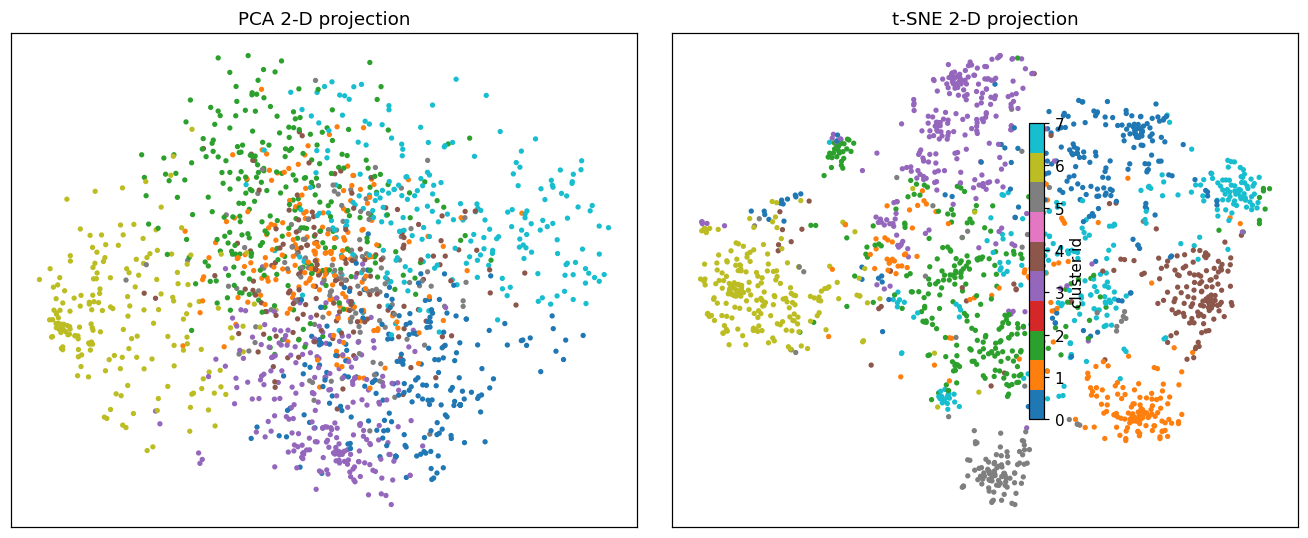

,cluster,size,representative_titles
0,0,219,Microcosmos: Le peuple de l'herbe (1996); Desi...
1,1,185,"Double Team (1997); Steal Big, Steal Little (1..."
2,2,271,Getting Away With Murder (1996); City of Angel...
3,3,260,"Innocent Sleep, The (1995); My Life and Times ..."
4,4,154,Go Fish (1994); Amityville: Dollhouse (1996); ...
5,5,122,Bent (1997); Bad Moon (1996); Frisk (1995); Al...
6,6,218,Destiny Turns on the Radio (1995); Touki Bouki...
7,7,238,"Quiet Man, The (1952); Red Rock West (1992); F..."


In [ ]:
# ======================================================================
#  • k-means on movie vectors
#  • 2-D scatter via PCA (fast) and t-SNE (slower, nicer)
#  • cluster summary table
# ======================================================================

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# 3.1  Normalise Q rows (helps k-means & cosine geometry)
# ----------------------------------------------------------------------
Q_norm = normalize(Q)                     # L2 row-norm = 1

# Choose a cluster count (tweak or compute via silhouette)
N_CLUSTERS = 8
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init='auto')
labels = kmeans.fit_predict(Q_norm)

# ----------------------------------------------------------------------
# 3.2  2-D embeddings for visualisation
# ----------------------------------------------------------------------
pca_2d  = PCA(n_components=2, random_state=42).fit_transform(Q_norm)
tsne_2d = TSNE(perplexity=40, metric='cosine', init='pca',
               random_state=42, n_iter=1000).fit_transform(Q_norm)

# ----------------------------------------------------------------------
# 3.3  Scatter plots (PCA & t-SNE)
# ----------------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=110)

scatter = ax[0].scatter(pca_2d[:,0], pca_2d[:,1], c=labels, s=6, cmap='tab10')
ax[0].set_title("PCA 2-D projection")
ax[0].set_xticks([]); ax[0].set_yticks([])

ax[1].scatter(tsne_2d[:,0], tsne_2d[:,1], c=labels, s=6, cmap='tab10')
ax[1].set_title("t-SNE 2-D projection")
ax[1].set_xticks([]); ax[1].set_yticks([])

fig.colorbar(scatter, ax=ax.ravel().tolist(), shrink=0.7, label='cluster id')
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 3.4  Cluster summary
# ----------------------------------------------------------------------
summary_rows = []
centroids = kmeans.cluster_centers_
dists = np.linalg.norm(Q_norm - centroids[labels], axis=1)
top_k = 5   

for cl in range(N_CLUSTERS):
    idx   = np.where(labels == cl)[0]
    size  = len(idx)
    rep_idx = idx[np.argsort(dists[idx])[:min(size, top_k)]]

    summary_rows.append({
        'cluster' : cl,
        'size'    : size,
        'representative_titles' : "; ".join(meta.iloc[rep_idx]['title'])
    })

cluster_summary = (
    pd.DataFrame(summary_rows)
      .sort_values('cluster')
)

display(cluster_summary)



In [110]:
cluster_summary['representative_titles'][6]

'Destiny Turns on the Radio (1995); I, Worst of All (Yo, la peor de todas) (1990); Hungarian Fairy Tale, A (1987); Yankee Zulu (1994); The Courtyard (1995)'

In [111]:
cluster_summary['representative_titles'][1]

'Double Team (1997); Steal Big, Steal Little (1995); Amos & Andrew (1993); Spy Hard (1996); Meet Wally Sparks (1997)'